In [1]:
import os,sys, re
from importlib import reload
import numpy as np
import pandas as pd
from Bio.Seq import reverse_complement
#import torch
print(os.getpid())
sys.path.append(r"/lab/weissman_imaging/puzheng/Softwares")


from ChromAn.src.library_tools.primers import load_fasta_to_DataFrame
#import MERFISH_probe_design.probe_design.OTTable_dict as ot

696768


In [2]:
from ChromAn.src.file_io.data_organization import Color_Usage, search_fovs_in_folders, color_usage_kwds

In [3]:
import ChromAn
reload(ChromAn.src.file_io.data_organization)
from ChromAn.src.file_io.data_organization import Data_Organization, search_fovs_in_folders
from ChromAn.src.file_io.dax_process import DaxProcesser
from ChromAn.src.visual_tools.interactive import imshow_mark_3d

In [4]:
# where the original data saves
data_folder =  r"/lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna"
#data_folder = os.path.join(data_home, '4T1Tumor', '20240504-fullyEdited4T1_MF8')

experiment_date = os.path.basename(data_folder).split('-')[0]
print(experiment_date)
# Color usage file marks the organization of imaging files
color_usage_filename = os.path.join(data_folder, 'Analysis', 'color_usage_MF4dna.csv')
print(os.path.exists(color_usage_filename))

20240510
True


In [5]:
# visualize some images:
folders, fovs = search_fovs_in_folders(data_folder)
sel_fov = 20

test_ref_filename = os.path.join(folders[0], fovs[sel_fov])
test_filename = os.path.join(folders[1], fovs[sel_fov])
# load ref
daxp_ref = DaxProcesser(test_ref_filename)
daxp_ref._load_image()
#daxp_ref._corr_hot_pixels()
# load
daxp = DaxProcesser(test_filename)
daxp._load_image()
#daxp._corr_hot_pixels()
daxp._calculate_drift(RefImage=daxp_ref.im_477, FiducialChannel='477')

- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna
-- 9 folders, 412 fovs detected.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna/H0M1/Conv_zscan_020.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna/H0M1/Conv_zscan_020_processed.hdf5
-- all used channels: ['748', '637', '477', '405']
-- single image size: [  18 2304 2304]
- Loaded images for channels:['748', '637', '477', '405'] in 2.251s.
Initialize DaxProcesser for file:/lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna/H1M2/Conv_zscan_020.dax
- New save file: /lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna/H1M2/Conv_zscan_020_processed.hdf5
-- all used channels: ['748', '637', '477']
-- single image size: [  18 2304 2304]
- Loaded images for channels:['748', '637', '477'] in 1.660s.
+ Calculate drift with fiducial_channel: 477
-- start aligning given source image 

(array([-0.02333333,  0.91      , 12.05666667]), 1)

### Quickly visualize bead image to find bead-localizing z-frame

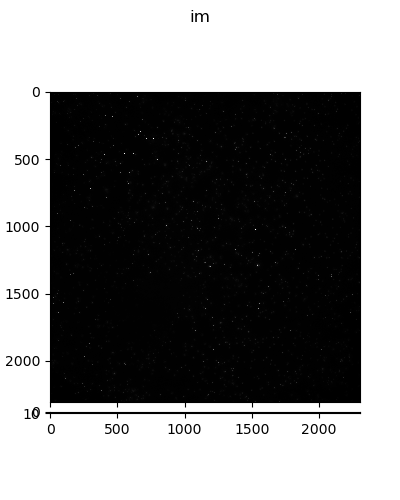

In [6]:
%matplotlib widget
imshow_mark_3d([daxp.im_477, daxp_ref.im_477], image_names=['im', 'ref'])

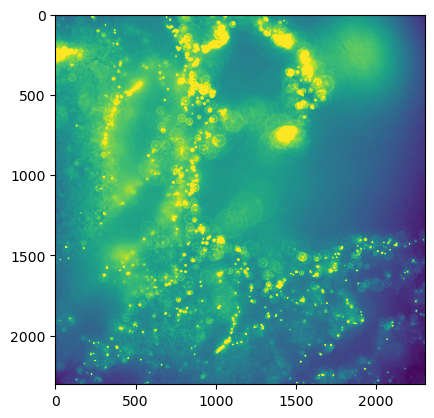

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp_ref.im_477[16], vmin=500, vmax=2000)
plt.show()

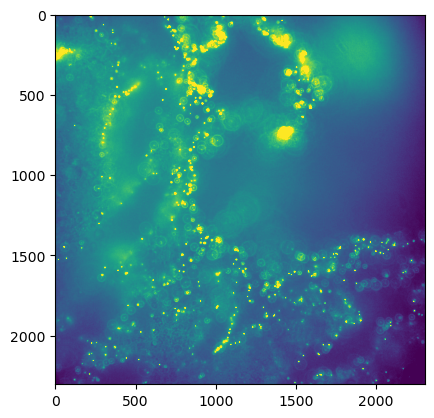

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(daxp.im_477[16], vmin=500, vmax=2000)

In [9]:
ref_Zstep = 16 # start from 0, manually check several images

In [10]:
# Load readout names:
library_folder = r'/lab/solexa_weissman/puzheng/MERFISH_Probes/4T1_MERFISH/MF4_4T1Primary16bit_DNAbit'
readout_filename = os.path.join(library_folder, 'readouts.csv')

if os.path.exists(readout_filename):
    readouts = pd.read_csv(readout_filename) 
else:
    # generate readout_file
    import MERFISH_probe_design.IO.file_io as fio
    merfish_bits_file = os.path.join(r'/lab/solexa_weissman/puzheng/References/Readouts', 'MERFISH_readouts.fasta')
    merfish_bits = fio.load_fasta_into_df(merfish_bits_file)
    # first 22 bits are for this library:
    readouts = {'Name':[_id.split('-')[-1] for _id in merfish_bits.loc[:, 'id']], 
                'Sequence':merfish_bits.loc[:, 'sequence']}
    readouts = pd.DataFrame(readouts)
    # save this readout
    readouts.to_csv(readout_filename, index=None)
# select names
readout_names = list(readouts['Name'])
print(len(readout_names))

16


In [11]:
# Generate data organization
data_organization_filename = f'../../merlin_parameters/dataorganization/{experiment_date}-{os.path.basename(library_folder).split("_")[0]}_{len(readout_names)}bit.csv'
_do = Data_Organization(data_organization_filename,)
if _do.is_empty():
    # create
    _do.create_from_colorUsage(color_usage_filename, data_folder,ref_Zstep, readout_names=readout_names)
    # save
    _do.save_to_file(overwrite=True)

- load color_usage from file: /lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna/Analysis/color_usage_MF4dna.csv
- searching in folder: /lab/weissman_imaging/puzheng/4T1Tumor/20240510-F242depc20um_MF4dna
-- 9 folders, 412 fovs detected.
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
0 bit-1 748 H0M1
1 bit-2 637 H0M1
2 bit-3 748 H1M2
3 bit-4 637 H1M2
4 bit-5 748 H2M3
5 bit-6 637 H2M3
6 bit-7 748 H3M4
7 bit-8 637 H3M4
8 bit-9 748 H4M5
9 bit-10 637 H4M5
10 bit-11 748 H5M6
11 bit-12 637 H5M6
12 bit-13 748 H6M7
13 bit-14 637 H6M7
14 bit-15 748 H7M8
15 bit-16 637 H7M8
- 16 MERFISH rows appended.
- PolyT row appended.
- DAPI row appended.
Saving data_organization into file: ../../merlin_parameters/dataorganization/20240510-MF4_16bit.csv.


In [12]:
_do

,channelName,readoutName,imageType,imageRegExp,bitNumber,imagingRound,color,frame,zPos,fiducialImageType,fiducialRegExp,fiducialImagingRound,fiducialFrame,fiducialColor
0,bit1,Stv_29,748_637_477_405_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,0,748,[0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 ...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_405_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,66,477
1,bit2,Stv_30,748_637_477_405_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,0,637,[1 5 9 13 17 21 25 29 33 37 41 45 49 53 57 61 ...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_405_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,0,66,477
2,bit3,Stv_31,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,1,748,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42 45 4...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,50,477
3,bit4,Stv_32,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,1,637,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 ...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,1,50,477
4,bit5,Stv_33,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,5,2,748,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42 45 4...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,50,477
5,bit6,Stv_35,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,6,2,637,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 ...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,2,50,477
6,bit7,Stv_36,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,7,3,748,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42 45 4...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,50,477
7,bit8,Stv_37,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,8,3,637,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 ...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,3,50,477
8,bit9,Stv_39,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,9,4,748,[0 3 6 9 12 15 18 21 24 27 30 33 36 39 42 45 4...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,50,477
9,bit10,Stv_40,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,10,4,637,[1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 ...,[-10.8 -9.6 -8.4 -7.2 -6.0 -4.8 -3.6 -2.4 -1.2...,748_637_477_s18,(?P<imageType>[\w|-]+)_(?P<fov>[0-9]+)_(?P<ima...,4,50,477


## Generate position file
NEW: loop through first round and generate the position_file:

In [13]:
from ChromAn.src.file_io.dax_process import DaxProcesser

reference_folder = folders[0]
positions = []

for _fov in fovs:
    daxp = DaxProcesser(os.path.join(reference_folder, _fov), verbose=False)
    positions.append(daxp._FindGlobalPosition(daxp.filename))
positions = np.array(positions)

In [14]:
target_position_filename = os.path.join(r"../../merlin_parameters/positions/", f"{experiment_date}_positions.txt")
print(f"target position file: {target_position_filename}")
np.savetxt(target_position_filename, positions, fmt='%.2f', delimiter=',')

target position file: ../../merlin_parameters/positions/20240510_positions.txt
